# TensorFlow Data Pipeline, Mini DenseNet ve GradCAM | Part 1 - 2

## Bölümler
#### Part 1
* Kütüphaneler

* Veri Yükleme
 * `tf.data.Dataset.list_files()` kullanarak.
 
 
* Ön İşleme ve Resimleri Augment Etme
 * `tf.data` pipeline'ı oluşturup, `tf.image` ve `tfa.image` kullanarak farklı dönüşümler uygulamak.

#### Part 2
* Modeli Oluşturmak
 * Mini DenseNet ve Layer Subclassing kullanmak
 * Modeli custom training loop kullanarak eğitmek

* Loss ve Accuracy Eğrilerini Plot Etmek
 * Training loop kullanarak toplanan loss ve accuracy değerlerini plot edip görmek

* Modelin performansını görmek için confusion matrix ve classification report kullanmak


#### Part 3 - Yüklenecek
* Gradient-weighted Class Activation Mapping (GradCAM)
 * Neden GradCAM'e ihtiyaç duyarız?
 * GradCAM Nedir?
 * GradCAM'i test setinde denemek

## Kütüphaneler

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, Dropout, \
                                    BatchNormalization, Conv2D, \
                                    MaxPooling2D, Concatenate, AveragePooling2D

import matplotlib.pyplot as plt

import os
import numpy as np

import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

import PIL
import glob
import pathlib

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

print('TF Version:', tf.__version__)
print('TFA Version:', tfa.__version__)

1 Physical GPUs, 1 Logical GPUs
TF Version: 2.7.0-dev20210904
TFA Version: 0.14.0


## Veri Yükleme

In [2]:
# Train ve Test klasörlerinin sırasıyla isimleri.
train_dir = "seg_train"
test_dir = "seg_test"

In [3]:
# Her ana klasör kendi için alt sınıf klasörlerine ayrıldığı için
# iki kere /* ekliyoruz. Böylece tüm resimleri almış olacağız.
train_dir_list = train_dir + '/*/*'
test_dir_list = test_dir + '/*/*'
train_dir_list, test_dir_list

('seg_train/*/*', 'seg_test/*/*')

In [4]:
# Dataset boyutunu direkt olarak görebilmek için
# bir fonksiyon yazıyoruz.
def data_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

In [5]:
# list_files bir tf.data olup, glob patterni eşleşen tüm dosyaları alacaktır.
list_ds_train = tf.data.Dataset.list_files(train_dir_list, 
                                     shuffle = False)

list_ds_test = tf.data.Dataset.list_files(test_dir_list, 
                                     shuffle = False)

list_ds_train = list_ds_train.shuffle(data_size(list_ds_train),
                                     reshuffle_each_iteration = False)

list_ds_test = list_ds_test.shuffle(data_size(list_ds_test),
                                     reshuffle_each_iteration = False)

# Datasetlerden birer tane örnek al.
for files in list_ds_train.take(1):
    print(files.numpy().decode('utf-8'))
    # seg_train\mountain\2174.jpg

for files in list_ds_test.take(1):
    print(files.numpy().decode('utf-8'))
    # seg_test\mountain\24204.jpg
    
# Datasetlerin boyutuna bak.
total_images = data_size(list_ds_train)
print('\nEğitim setinde %d resim var' %(total_images)) # 14034 

total_test = data_size(list_ds_test)
print('\nTest setinde %d resim var' %(total_test)) # 3000

seg_train\mountain\11355.jpg
seg_test\buildings\21763.jpg

Eğitim setinde 14034 resim var

Test setinde 3000 resim var


In [6]:
# Sınıf isimlerini dizinden almak için pathlib kullanıyoruz.
data_dir = pathlib.Path(train_dir)

class_names = [files.name for files in data_dir.glob('*/')]

# Alfabetik olarak sırala.
class_names = np.array(sorted(class_names), dtype = 'object')

print(class_names) # ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [7]:
# Train datasından validation set oluşturmak için
# take() ve skip() fonksiyonlarını kullanabiliriz.
val_size = int(total_images * 0.1)

list_ds_val = list_ds_train.take(val_size)
list_ds_train = list_ds_train.skip(val_size)

print('Train:', data_size(list_ds_train)) # 12631
print('Val:', data_size(list_ds_val)) # 1403
print('Test:', data_size(list_ds_test)) # 3000

# Overlap var mı diye kontrol et.
train = []
for x in list_ds_train:
    train.append(x.numpy().decode('utf-8'))

val = []
for x in list_ds_val:
    val.append(x.numpy().decode('utf-8'))
    
len(set(train).intersection(set(val))) # 0

Train: 12631
Val: 1403
Test: 3000


In [9]:
def get_label(files_path):
    # contents tensor içeriği:
    # <tf.Tensor: shape=(6,), dtype=string, numpy=
    # array([... b'seg_train', # Son iki string sınıfı ve resmin ismini içeriyor.
    #        b'glacier', b'10.jpg'], dtype=object)>

    contents = tf.strings.split(files_path, os.path.sep)
       
    # class_idx tensor içeriği:
    # <tf.Tensor: shape=(6,), dtype=bool, numpy=array([False, False, 
                                        # True, False, False, False])>
    class_idx = contents[-2] == class_names
  
    # Return: tf.where(class_idx)
    # <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[2]])>
    # Alternatif olarak tf.argmax(class_idx) kullanabilirdik
    return tf.where(class_idx)[0][0]

def decode_img(image):
    # tf.io.read_file ile okunmuş resimlerin tf.image.decode_jpeg
    # ile decode edilmesi gerekir. Bu sayede resimleri array formatına
    # çevirmiş oluruz. channel=3 diyerek de RGB olduğunu belirtiyoruz.
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def process_path(file_path):
    label = get_label(file_path)
  
    # img :<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\x0\ ...
    # tf.io.read_file içeriği olduğu gibi okur, onun için decode edilmesi gerekir.
    image = tf.io.read_file(file_path)

    # Şimdi ise resimler artık array formatındadır.
    image = decode_img(image)
    return image, label

In [10]:
# num_parallel_calls ile mapping işlemini parallelize etmiş oluyoruz.
# tf.data.AUTOTUNE, tf.data çalışma zamanı sırasında paralellik düzeyine karar verecektir.

train_ds = list_ds_train.map(process_path, 
                             num_parallel_calls=tf.data.AUTOTUNE)

val_ds = list_ds_val.map(process_path, 
                         num_parallel_calls=tf.data.AUTOTUNE)

test_ds = list_ds_test.map(process_path, 
                           num_parallel_calls=tf.data.AUTOTUNE)

## Ön İşleme ve Dönüşüm ~ Pipeline

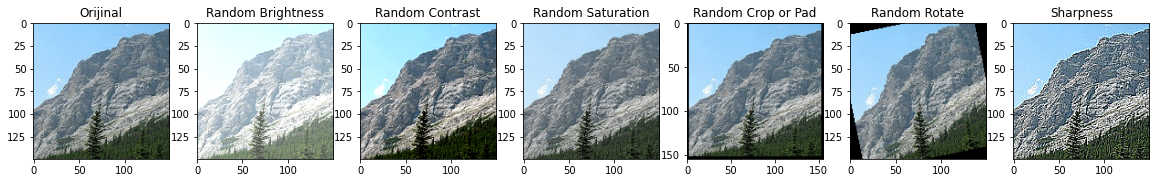

In [11]:
# tf.image ve tfa.image ile resimleri augment edebilir veya üzerlerinde random
# dönüşümler uygulayabiliriz.

for x, y in train_ds.take(1): # Datasetten 1 tane resim ve label çifti alır.
    seed = (52, 2)
    
    # Burada tf.image ve tfa.image altında olan fonksiyonları göstereceğim.
    # Random dönüşümler için stateless_random_* olanları kullanıyoruz.
    # Farkını aşağıda açıklıyorum.
    
    random_bright = tf.image.stateless_random_brightness(x, max_delta=1.0, 
                                                       seed = seed)

    random_contrast = tf.image.stateless_random_contrast(x, 0.2, 2.0,
                                                       seed = seed)

    random_saturation = tf.image.stateless_random_saturation(x, 0.2, 1.0,
                                                           seed = seed)

    random_crop_or_pad = tf.image.resize_with_crop_or_pad(x, 
                               tf.shape(x).numpy()[0] + 5, 
                               tf.shape(x).numpy()[1] + 5)

    random_rotate = tfa.image.rotate(x, tf.constant(tf.random.uniform((1,), 
                                                        minval = 0.01,
                                                        maxval = 0.4)))

    sharpness = tfa.image.sharpness(x, 5.1)

    plt.figure(figsize = (20, 12))

    plt.subplot(1, 7, 1)
    plt.imshow(x.numpy() / 255.0)
    plt.title('Orijinal')

    plt.subplot(1, 7, 2)
    plt.imshow(random_bright.numpy() / 255.0)
    plt.title('Random Brightness')

    plt.subplot(1, 7, 3)
    plt.imshow(random_contrast.numpy() / 255.0)
    plt.title('Random Contrast')

    plt.subplot(1, 7, 4)
    plt.imshow(random_saturation.numpy() / 255.0)
    plt.title('Random Saturation')

    plt.subplot(1, 7, 5)
    plt.imshow(random_crop_or_pad.numpy() / 255.0)
    plt.title('Random Crop or Pad')

    plt.subplot(1, 7, 6)
    plt.imshow(random_rotate.numpy() / 255.0)
    plt.title('Random Rotate')

    plt.subplot(1, 7, 7)
    plt.imshow(sharpness.numpy() / 255.0)
    plt.title('Sharpness')

In [12]:
def resize_and_one_hot(image, label):
    # Resimleri float32'ye cast ediyoruz.
    image = tf.cast(image, tf.float32)
    
    # Resimlerin hepsini 128 x 128 boyutuna getiriyoruz.
    image = tf.image.resize(image, [128, 128])
    
    # Resimleri normalize edip, labelları one hot encoded şeklinde
    # döndürüyoruz.
    return image / 255.0, tf.one_hot(label, 6)

#### Normal tf.image.random ve tf.stateless_random operasyonları arasındaki fark:
* TensorFlow'da random resim transformasyonları için fonksiyonlar genel olarak iki gruba ayrılır.
  * tf.image.random.* ve
  * tf.image.stateless_random.*


* `tf.image.random` operasyonlarının kullanılması tavsiye edilmez çünkü arka planda TF 1.X'den kalan bazı fonksiyonları kullanırlar. Onun yerine `tf.image.stateless_random` fonksiyonlarını kullanacağız. 

In [13]:
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_one_hot(image,label)

    # Dönüşümleri iki gruba ayıracağız.
    transformation_selection = tf.random.uniform([], minval = 0, 
                                                 maxval = 1, 
                                                 dtype = tf.float32)
    
    # İki grubu kendi içinde alt gruplara böleceğiz.
    
    # 1.gruptaki dönüşümleri uygulama ihtimali  
    prob_1 = tf.random.uniform([], minval = 0, maxval = 1, dtype = tf.float32)
    
    # 2.gruptaki dönüşümleri uygulama ihtimali        
    prob_2 = tf.random.uniform([], minval = 0, maxval = 1, dtype = tf.float32)
    
    # Yani her dönüşümün uygulanmak için %25 şansı var.
    # Her resme sadece bir dönüşüm uygulayacağız.
    image = tf.cond(tf.greater(transformation_selection, 0.5),

                    # tf.cond fonksiyonlarının -callable- olmasını istediği
                    # için lambda yazıyoruz.
                    
                    # Eğer ki transformation_selection > 0.5 ise buraya gelecek.
                    # Eğer prob_1 > 0.5 kontrastı değiştir. Değilse parlaklığı değiştir.
                    lambda: tf.cond(tf.greater(prob_1, 0.5),
                            lambda: tf.image.stateless_random_contrast(image, 0.1, 0.5,
                                                     seed = seed), 
                            lambda: tf.image.stateless_random_brightness(image, max_delta=0.3, 
                                                     seed = seed),
                           ),
                    
                    # Eğer ki transformation_selection < 0.5 ise buraya gelecek.
                    # Eğer prob_2 > 0.5 saturation uygula. Değilse resmi random döndür.
                    lambda: tf.cond(tf.greater(prob_2, 0.5),
                            lambda: tf.image.stateless_random_saturation(image, 0.01, 0.1,
                                                           seed = seed),
                            lambda: tfa.image.rotate(image, tf.random.uniform((1,), 
                                                        minval = 0.01,
                                                        maxval = 0.2))                          
                          )     
                   )

    #   new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    #   Eğer ki tf.cond dışında farklı seed kullanıp farklı dönüşümler uygulamak isterseniz
    #   new_seed'i aşağıdaki gibi fonksiyona geçebilirsiniz.
    """
    Örnek: tf.image.stateless_random_saturation(image, 0.01, 0.1,
                                              seed = new_seed)
    """
    return image, label

In [14]:
random_number = tf.random.Generator.from_seed(52222, alg='philox')

# Ana fonksiyonumuz seed alacağı için, bunu başka bir fonksiyonun içine
# koyup, ana fonksiyonumuzu çağırabiliriz. 
def augment_wrapper(x, y):
    seed = random_number.make_seeds(2)[0]
    image, label = augment((x, y), seed)
    return image, label

In [15]:
# Shuffle ve Prefetch'i aşağıda açıklıyorum.

train_ds = (
    train_ds
    .map(augment_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .shuffle(128)
    .prefetch(tf.data.AUTOTUNE)
)

# Validasyon ve Test setlerini augment etmiyoruz.
val_ds = (
    val_ds
    .map(resize_and_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .shuffle(128)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .map(resize_and_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .shuffle(128)
    .prefetch(tf.data.AUTOTUNE)
)

### shuffle() nasıl çalışır?
* Shuffle fonksiyonunu çağırınca buffer_size diye bir parametre veriyoruz. Mesela, datasetimizde 100K element varsa ve size'ı 1000 olarak verirsek, buffer (arabellek) ilk 1000 element ile doldurulacak ve birisi rastgele seçilecek. Bundan sonra ise, tekrar rastgele eleman seçmeden önce bunu 1000 ve ilk elemanla değiştirecek.


### prefetch() nasıl çalışır?
* Prefetch() fonksiyonu model eğitimi ve ön işleme sürecini overlap etmeye yarayan bir fonksiyodundur. Örnek olarak, GPU n. adımdaki gelen resimleri/verileri işleyip hesaplama yaparken, CPU da bir sonraki adımı hazırlıyor olacak.

* Prefetch ile CPU, GPU model eğitimi yaparken boşta durmayacak, sonraki batch'i hazırlıyor olacak. 

--> prefetch() olmadan:
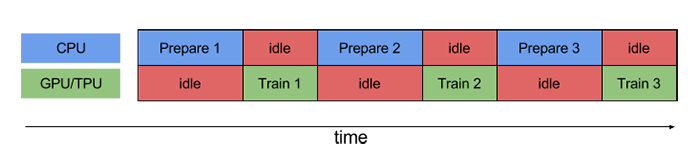

--> prefetch() ile:
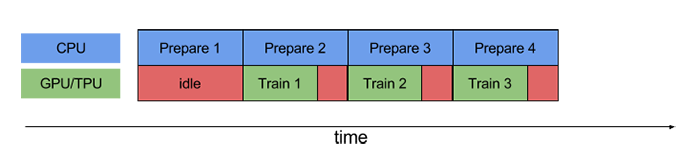

In [16]:
train_ds

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 6)), types: (tf.float32, tf.float32)>

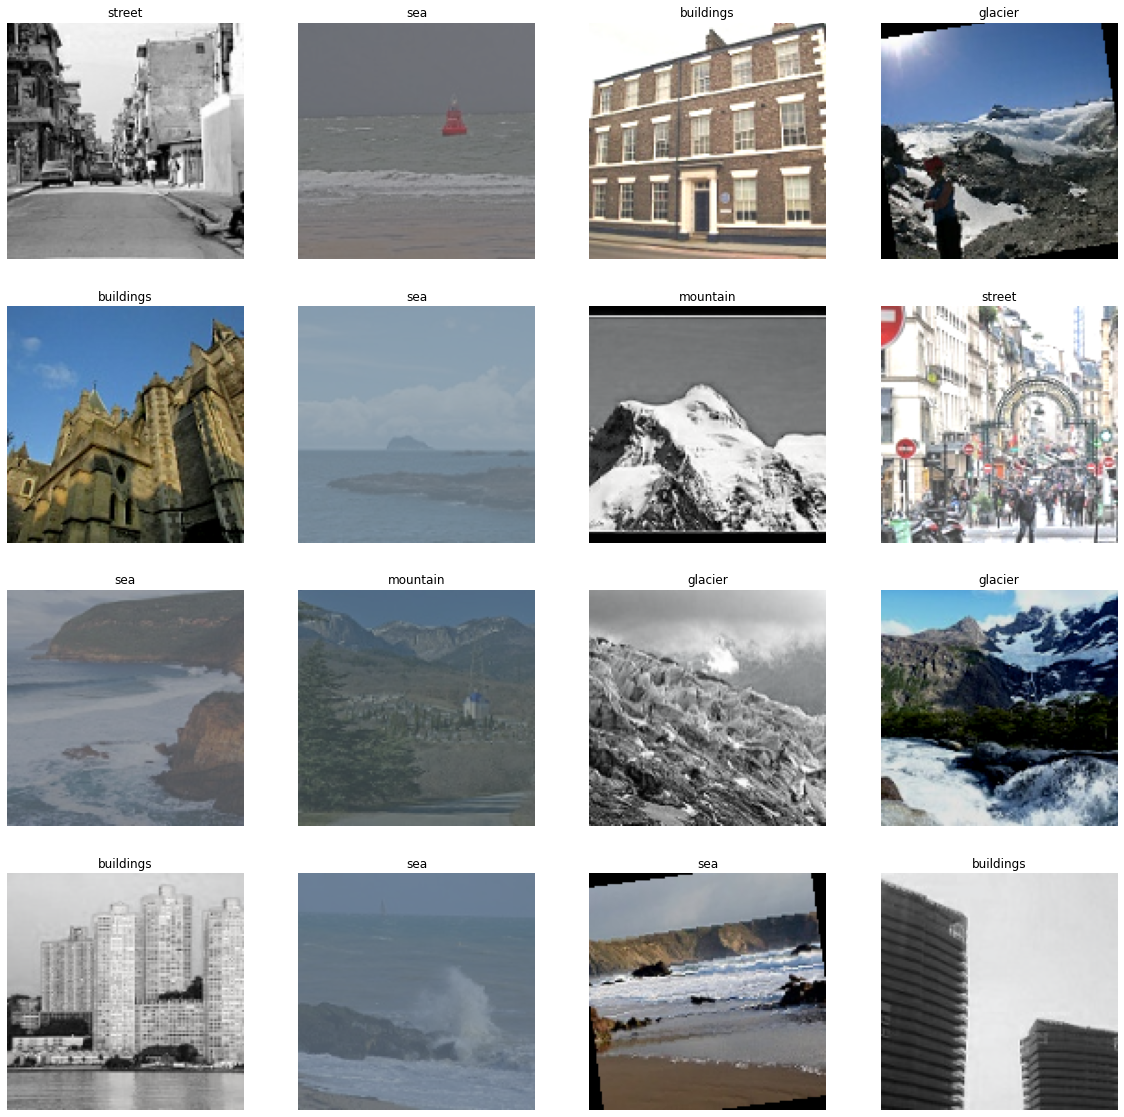

In [17]:
plt.figure(figsize=(20, 20))
plt.tight_layout()

# tf.data datasetimizi batchlediğimizden ötürü take(1) bütün batch'i döndürür.
# Ondan dolayı içeride bir for açıp batch içinde bulunan resimler arasında dönüyoruz.
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(tf.clip_by_value(images[i], 0, 1).numpy())
        plt.title(class_names[tf.argmax(labels[i], axis = -1)])
        plt.axis("off")

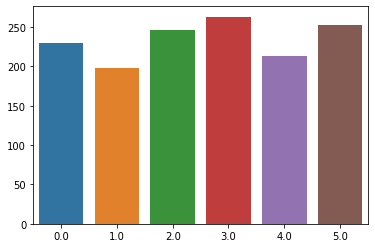

In [18]:
# tf.data.Datasetlerde sınıf label dağılımlarını saymak için daha iyi bir
# yöntem var mı bilmiyorum. Burada basitçe labelları tek tek sayıyoruz.

# Büyük datasetlerde çok iyi bir yöntem olmayabilir.

labels, counts = np.unique(np.fromiter(val_ds.unbatch().map(lambda x, y: tf.argmax(y, axis = -1)), np.float32), 
                       return_counts=True)
sns.barplot(labels, counts)
plt.show()

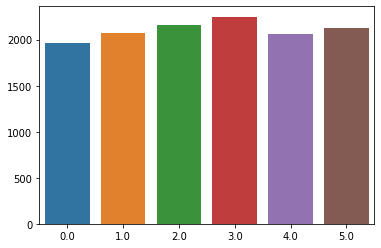

In [19]:
labels, counts = np.unique(np.fromiter(train_ds.unbatch().map(lambda x, y: tf.argmax(y, axis = -1)), np.float32), 
                       return_counts=True)
sns.barplot(labels, counts)
plt.show()

In [20]:
# Veya dizinlerden sınıfların dağılımını sayabiliriz.
images_per_class = []
class_name = []
for i in os.listdir('./seg_train'):
    train_class = os.listdir(os.path.join('seg_train', i))
    images_per_class.append(len(train_class))
    class_name.append(i)
    print('Class: {} = Total Images: {} \n'.format(i, len(train_class)))

Class: buildings = Total Images: 2191 

Class: forest = Total Images: 2271 

Class: glacier = Total Images: 2404 

Class: mountain = Total Images: 2512 

Class: sea = Total Images: 2274 

Class: street = Total Images: 2382 



## Modeli Oluşturalım
* Modeli Functional API kullanarak yazacağız.

In [21]:
input_shape = (128,128,3)

# Input tensor
input_layer = tf.keras.Input(input_shape)

# 2 Convolutions + BN + Swish Aktivasyonu
x = Conv2D(16, 5)(input_layer)
x = Conv2D(32, 3)(x)
x = BatchNormalization()(x)
x = tf.nn.silu(x) # swish

x_out_1 = MaxPooling2D((3,3))(x) # Normal MaxPooling

# Concatenate --> 2 Conv Layers & Skip Connection
x = Conv2D(32, 3, padding = 'same')(x_out_1)
x = Conv2D(64, 3, padding = 'same')(x)
x = BatchNormalization()(x)
x = tf.nn.silu(x)
residual_1 = tf.keras.layers.Concatenate()([x,x_out_1])

# Bu bağlantıyı görselleştirmek istersek:

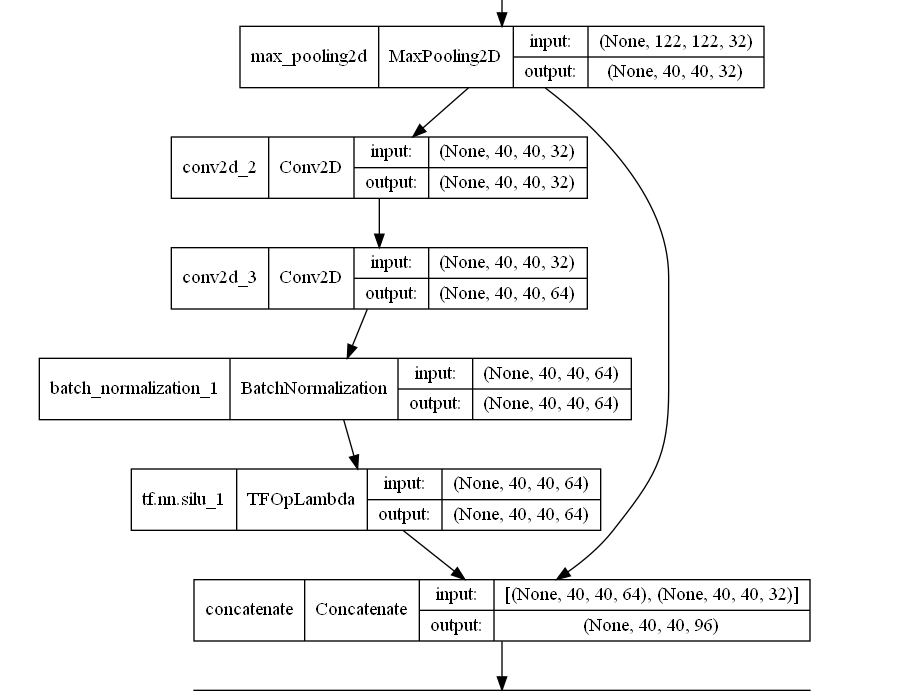

In [22]:
# Aynı şeyleri yazmak yerine class olarak tanımlayalım.

class SkipConnectionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        # Sınıf değişkenlerini setup ediyoruz.
        super(SkipConnectionLayer, self).__init__()
        self.units = units

    def build(self, units):
        # Layerları ekliyoruz.
        self.conv = Conv2D(self.units, 
                                kernel_size= (3, 3),
                                 padding = 'same')

        self.conv2 = Conv2D(self.units, 
                               kernel_size= (3, 3),
                               padding = 'same')
        self.bn = BatchNormalization()

    def call(self, inputs, training = False):
        # Forward propagation burada oluyor.
        
        # Dropout, BatchNorm gibi layerların davranışları train ve test
        # zamanında farklıdır. Modelden prediction alırken bu layerların
        # aktif olmasını istemeyiz. Training, bu davranışı kontrol ediyor.
        x = self.conv(inputs)
        x = self.conv2(x)

        x = self.bn(x, training = training)
        x = tf.nn.silu(x)
        return Concatenate()([x, inputs])
    
    # get_config'i override ediyoruz, böylece TF modeli
    # kaydederken veya yüklerken sorun yaşamayacak.
    # Kaynak koduna bakıp daha fazla bilgi edinmek isterseniz:
    # https://github.com/tensorflow/tensorflow/blob/cdf2c541c3dd3fb6d03cce4d23fc6c548bc9017c/tensorflow/python/keras/engine/base_layer.py#L539-L594
    def get_config(self):
        return {'units': self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)     

In [23]:
# SkipConnection layerlarını subclass olarak ifade ettik.

x = SkipConnectionLayer(64)(residual_1)
x = SkipConnectionLayer(128)(x)
x = SkipConnectionLayer(256)(x)

x = MaxPooling2D((3,3))(x)

x = Conv2D(512, (3,3), padding = 'same',
                                   name = 'last_conv_layer')(x)
x = tf.nn.silu(x)

# Average Pooling
x = AveragePooling2D((2,2), name = 'avg_pool')(x)

# Final layer
x = GlobalMaxPooling2D()(x)
x = Dense(6, activation = 'softmax', name = 'last_dense')(x)
# 6 class ve multi-class classification olduğu için
# softmax aktivasyonu kullandık.

model = tf.keras.Model(inputs = input_layer, 
                       outputs = x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3  0           []                               
                                )]                                                                
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 124, 16  1216        ['input_1[0][0]']                
                                )                                                                 
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 122, 122, 32  4640        ['conv2d[0][0]']                 
                                )                                                             

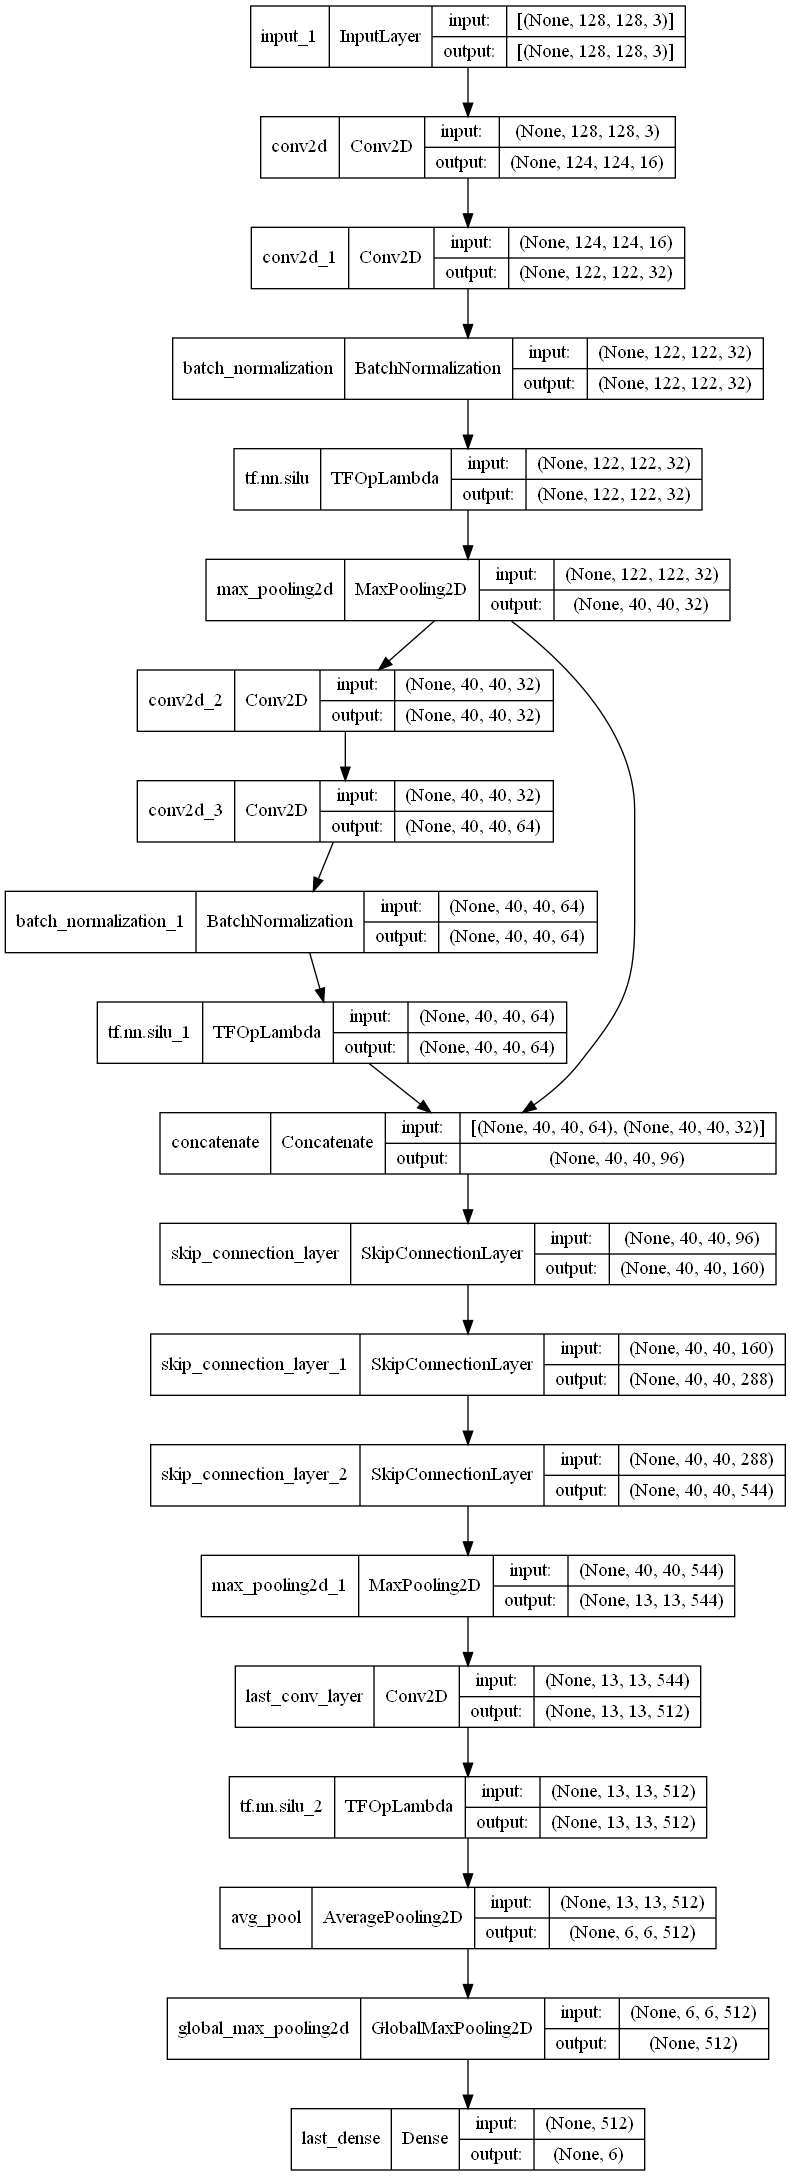

In [24]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [25]:
# RAdam ve Lookahead'i beraber kullanıyoruz.
# Bu şekilde daha stabil bir training süreci elde edeceğiz.

radam = tfa.optimizers.RectifiedAdam(learning_rate = 0.0001)
optimizer = tfa.optimizers.Lookahead(radam, sync_period=4, slow_step_size=0.5)

# Labellar one hot encoded olduğu için CategoricalCrossentropy
# OHE olmasaydı SparseCategoricalCrossentropy
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Metrikler için de aynısı geçerlidir.
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
loss_fn

#### tf.function
* Hesaplama açısından maliyetli olan görevlerde `@tf.function` dekoratörü kullanıyoruz. Bu şekilde dekore edilmiş fonksiyonlar çağrılabilir bir TensorFlow graphına dönüşecektir. Böylece, eager execution yapmak yerine daha hızlı olan **graph execution** kullanıyor olacağız.

<br>

#### train_step(x, y)
* Her batch için bir GradientTape() scope'u açıyoruz.
* Bu scope içinde modele forward pass yapıp loss hesaplıyoruz.
* Loss hesabından sonra scope dışında, ağırlıkların loss fonksiyonuna göre gradyanlarını alıyoruz.
* Ondan sonra optimizer'ımızı kullanarak ağırlıkları, gradyanlara dayalı olarak güncelliyoruz.
* En son ise metrik güncelliyoruz ve o batch'in loss değerini döndürüyoruz.

In [26]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        preds = model(x, training=True)
        loss_value = loss_fn(y, preds)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, preds)
    return loss_value

#### val_step(x, y)
* `train_step` fonksiyonu ile benzerdir. Bu sefer sadece forward pass yapıp loss hesaplıyoruz. 
* `training = False` olmasının sebebi, BatchNorm - Dropout gibi layerların tahmin alırken aktif olmasını istemiyor oluşumuz. Ondan dolayı `False` dedik.

In [27]:
@tf.function
def val_step(x, y):
    val_preds = model(x, training=False)
    val_loss = loss_fn(y, val_preds)
    val_acc_metric.update_state(y, val_preds)
    return val_loss

In [28]:
data_size(train_ds)

395

In [29]:
epochs = 48

train_acc_per_epoch = []
val_acc_per_epoch = []

train_mean_loss = [] # Her epoch'un ortalaması
validation_mean_loss = [] # Her epoch'un ortalaması

for epoch in range(epochs):
    # train_loss ve val_loss listelerini batchlerin loss değerlerini tutmak
    # için kullanacağız. Ondan dolayı her epochta sıfırlıyoruz.
    train_loss = []
    validation_loss = []
    
    print("\nIn epoch %d" % (epoch,))
    start_time = time.time()

    # Datasetin batchleri üzerinde iterate ediyoruz.
    for step, (x_train_batch, y_train_batch) in enumerate(train_ds):
        train_loss_steps = train_step(x_train_batch, y_train_batch)
        
        # Her batchin loss değerini listemize ekliyoruz.
        train_loss.append(train_loss_steps.numpy())
        
        # Her 78 step için bir bilgi print ediyoruz.
        # Step: len(Toplam data) / batch size
        if step % 78 == 0:
            print(
                "Step %d, training loss: %.5f"
                % (step, float(train_loss_steps))
            )
            
            print("Modelin gördüğü toplam örnek sayısı: %d" % ((step + 1) * 32))

    # Her epoch sonunda metrikleri gösteriyoruz.
    train_acc = train_acc_metric.result()
    
    print('\nBu epoch için ortalama training loss: %.5f' %(np.mean(train_loss)))
    print('Bu epoch için training accuracy: %.5f' % (float(train_acc)))

    # Metrikleri epoch sonunda resetliyoruz ki üstüne yazmasın.
    train_acc_metric.reset_states()

    # Her epoch sonunda validasyon setimizi predict edelim.
    # Aynı batchler üzerinde ilerleme mantığı burada da geçerli.
    for x_test_batch, y_test_batch in val_ds:
        val_loss_steps = val_step(x_test_batch, y_test_batch)
        validation_loss.append(val_loss_steps.numpy())
        
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    
    # Ortalama değerleri tutacağımız listeleri güncelliyoruz.
    # Her batchin ortalama değerini alıp listelere ekliyoruz.
    train_mean_loss.append(np.mean(train_loss))
    validation_mean_loss.append(np.mean(validation_loss))
    
    # Accuracy metriklerini de aynı mantıkla ortalama alarak ekliyoruz.
    train_acc_per_epoch.append(train_acc.numpy())
    val_acc_per_epoch.append(val_acc.numpy())
    
    # Bu epoch için bilgiler.
    print('\nBu epoch için ortalama validation loss: %.5f' %(np.mean(validation_loss)))
    print('Bu epoch için ortalama validation accuracy: %.5f' % (float(val_acc)))
    
    print('\nBu epoch için geçen süre: %.2fs' % (time.time() - start_time))
    print('--' * 30)


In epoch 0
Step 0, training loss: 2.65141
Modelin gördüğü toplam örnek sayısı: 32
Step 78, training loss: 1.49917
Modelin gördüğü toplam örnek sayısı: 2528
Step 156, training loss: 1.26287
Modelin gördüğü toplam örnek sayısı: 5024
Step 234, training loss: 1.23970
Modelin gördüğü toplam örnek sayısı: 7520
Step 312, training loss: 0.72208
Modelin gördüğü toplam örnek sayısı: 10016
Step 390, training loss: 1.05294
Modelin gördüğü toplam örnek sayısı: 12512

Bu epoch için ortalama training loss: 1.27946
Bu epoch için training accuracy: 0.50495

Bu epoch için ortalama validation loss: 1.27022
Bu epoch için ortalama validation accuracy: 0.54455

Bu epoch için geçen süre: 128.18s
------------------------------------------------------------

In epoch 1
Step 0, training loss: 1.07938
Modelin gördüğü toplam örnek sayısı: 32
Step 78, training loss: 0.83070
Modelin gördüğü toplam örnek sayısı: 2528
Step 156, training loss: 1.13633
Modelin gördüğü toplam örnek sayısı: 5024
Step 234, training loss:

Step 0, training loss: 0.27648
Modelin gördüğü toplam örnek sayısı: 32
Step 78, training loss: 0.36739
Modelin gördüğü toplam örnek sayısı: 2528
Step 156, training loss: 0.39495
Modelin gördüğü toplam örnek sayısı: 5024
Step 234, training loss: 0.38887
Modelin gördüğü toplam örnek sayısı: 7520
Step 312, training loss: 0.38912
Modelin gördüğü toplam örnek sayısı: 10016
Step 390, training loss: 0.12407
Modelin gördüğü toplam örnek sayısı: 12512

Bu epoch için ortalama training loss: 0.37761
Bu epoch için training accuracy: 0.86644

Bu epoch için ortalama validation loss: 0.34166
Bu epoch için ortalama validation accuracy: 0.88810

Bu epoch için geçen süre: 100.76s
------------------------------------------------------------

In epoch 12
Step 0, training loss: 0.23184
Modelin gördüğü toplam örnek sayısı: 32
Step 78, training loss: 0.31441
Modelin gördüğü toplam örnek sayısı: 2528
Step 156, training loss: 0.28346
Modelin gördüğü toplam örnek sayısı: 5024
Step 234, training loss: 0.18639
Mo

Step 0, training loss: 0.20674
Modelin gördüğü toplam örnek sayısı: 32
Step 78, training loss: 0.19139
Modelin gördüğü toplam örnek sayısı: 2528
Step 156, training loss: 0.19840
Modelin gördüğü toplam örnek sayısı: 5024
Step 234, training loss: 0.06236
Modelin gördüğü toplam örnek sayısı: 7520
Step 312, training loss: 0.10066
Modelin gördüğü toplam örnek sayısı: 10016
Step 390, training loss: 0.39607
Modelin gördüğü toplam örnek sayısı: 12512

Bu epoch için ortalama training loss: 0.21470
Bu epoch için training accuracy: 0.92281

Bu epoch için ortalama validation loss: 0.41568
Bu epoch için ortalama validation accuracy: 0.86244

Bu epoch için geçen süre: 101.52s
------------------------------------------------------------

In epoch 23
Step 0, training loss: 0.22128
Modelin gördüğü toplam örnek sayısı: 32
Step 78, training loss: 0.17203
Modelin gördüğü toplam örnek sayısı: 2528
Step 156, training loss: 0.30563
Modelin gördüğü toplam örnek sayısı: 5024
Step 234, training loss: 0.20271
Mo

Step 0, training loss: 0.05729
Modelin gördüğü toplam örnek sayısı: 32
Step 78, training loss: 0.06347
Modelin gördüğü toplam örnek sayısı: 2528
Step 156, training loss: 0.10828
Modelin gördüğü toplam örnek sayısı: 5024
Step 234, training loss: 0.05795
Modelin gördüğü toplam örnek sayısı: 7520
Step 312, training loss: 0.12544
Modelin gördüğü toplam örnek sayısı: 10016
Step 390, training loss: 0.09289
Modelin gördüğü toplam örnek sayısı: 12512

Bu epoch için ortalama training loss: 0.13396
Bu epoch için training accuracy: 0.95432

Bu epoch için ortalama validation loss: 0.48464
Bu epoch için ortalama validation accuracy: 0.86814

Bu epoch için geçen süre: 100.71s
------------------------------------------------------------

In epoch 34
Step 0, training loss: 0.21512
Modelin gördüğü toplam örnek sayısı: 32
Step 78, training loss: 0.02995
Modelin gördüğü toplam örnek sayısı: 2528
Step 156, training loss: 0.04209
Modelin gördüğü toplam örnek sayısı: 5024
Step 234, training loss: 0.15866
Mo

Step 0, training loss: 0.08020
Modelin gördüğü toplam örnek sayısı: 32
Step 78, training loss: 0.02990
Modelin gördüğü toplam örnek sayısı: 2528
Step 156, training loss: 0.05379
Modelin gördüğü toplam örnek sayısı: 5024
Step 234, training loss: 0.03561
Modelin gördüğü toplam örnek sayısı: 7520
Step 312, training loss: 0.06545
Modelin gördüğü toplam örnek sayısı: 10016
Step 390, training loss: 0.07517
Modelin gördüğü toplam örnek sayısı: 12512

Bu epoch için ortalama training loss: 0.09261
Bu epoch için training accuracy: 0.96873

Bu epoch için ortalama validation loss: 0.41874
Bu epoch için ortalama validation accuracy: 0.88525

Bu epoch için geçen süre: 99.95s
------------------------------------------------------------

In epoch 45
Step 0, training loss: 0.16880
Modelin gördüğü toplam örnek sayısı: 32
Step 78, training loss: 0.14193
Modelin gördüğü toplam örnek sayısı: 2528
Step 156, training loss: 0.05994
Modelin gördüğü toplam örnek sayısı: 5024
Step 234, training loss: 0.01349
Mod

## Loss ve Accuracy Değerlerini Plot Edelim

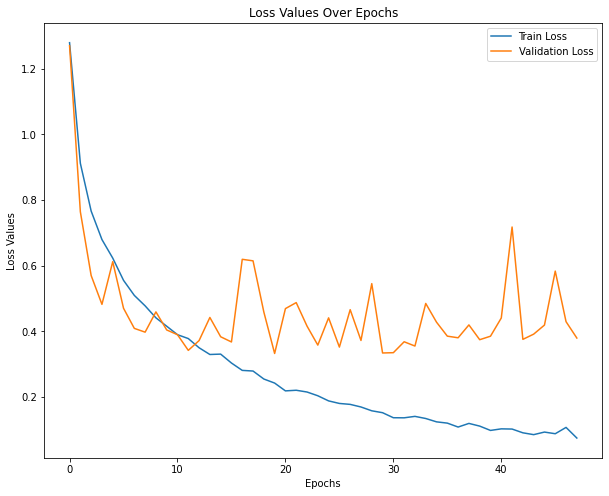

In [30]:
plt.figure(figsize = (10, 8))

plt.plot(train_mean_loss, label = 'Train Loss')
plt.plot(validation_mean_loss, label = 'Validation Loss')
plt.title('Loss Values Over Epochs')

plt.xlabel('Epochs')
plt.ylabel('Loss Values')

plt.legend()
plt.show()

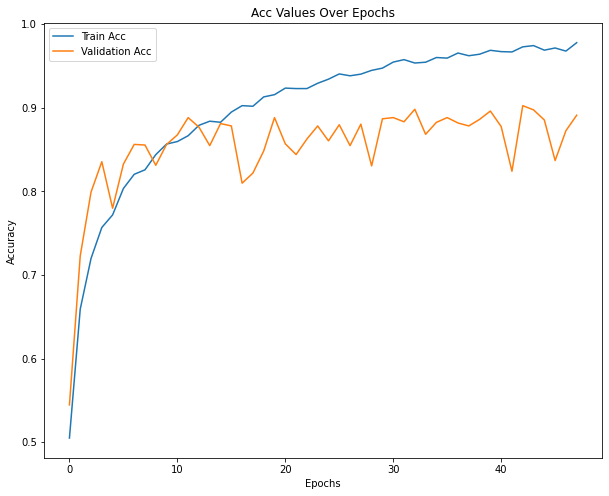

In [31]:
plt.figure(figsize = (10, 8))

plt.plot(train_acc_per_epoch, label = 'Train Acc')
plt.plot(val_acc_per_epoch, label = 'Validation Acc')
plt.title('Acc Values Over Epochs')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [32]:
# Optimizer'ı dahil etmeyecek şekilde modeli save edelim.
model.save('SkipConnectionModelConv2D-TR.h5', include_optimizer = False)

## Modelin Test Setindeki Performansı

In [33]:
# Datasetten tahminleri ve gerçek değerleri toplayacağız.
# Bu şekilde sklearn metriklerini kullanabiliriz.

prediction = np.array([])
true_label =  np.array([])

# x: Resimler // y: Labellar
for x, y in test_ds:
    
    # tf.data Datasetimizi batchlediğimiz için bize batchler döndürecek
    # Yani x.shape = (32, 128, 128, 3)
    # 32, daha önce belirlediğimiz batch size'ı.
    # Küçük veriler için model.predict yerine direkt __call__ metodunu kullanabiliriz.
    # model.predict(x) yerine --> model(x)
    prediction = np.concatenate([prediction,
                                 np.argmax(model(x), 
                                           axis = -1)])
    # Baskın sınıfı bulmak için argmax kullanıyoruz.
    # [0.1, 0.2, 0.1, 0.1, 0.5, 0.1] --> Her index bir sınıfa karşılık geliyor.
    # Softmax çıktıları toplamı 1 olacaktır. Mesela burada 5.sınıf seçilecektir.
    # Çünkü çıktısı en yüksek olan 5.sınıf. 
    
    true_label = np.concatenate([true_label, 
                                 np.argmax(y.numpy(), 
                                           axis = -1)])
    # Labellar da one-hot-encoded olduğu için argmax uyguluyoruz
    # Onlara integer olarak ihtiyacımız var.
    
    # x ve y datasetten alınan batchler olduğu için de 
    # axis = 0'da concat ettik.

In [34]:
# Datasetten alınan labellar
true_label

array([5., 2., 4., ..., 2., 1., 2.])

In [35]:
# Modelin tahmin ettikleri
prediction

array([5., 2., 4., ..., 2., 1., 2.])

<AxesSubplot:>

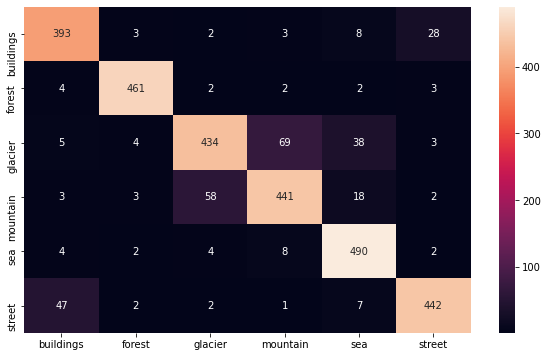

In [36]:
# CM'i oluşturalım.
cm = confusion_matrix(true_label, prediction)  

index = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']  
columns = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']  

cm_df = pd.DataFrame(cm,columns,index)                      

plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True, fmt='d')

In [37]:
# Aynı şekilde tahmin ve doğruları vererek CR'a bakalım:
print(classification_report(true_label, prediction))

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       437
         1.0       0.97      0.97      0.97       474
         2.0       0.86      0.78      0.82       553
         3.0       0.84      0.84      0.84       525
         4.0       0.87      0.96      0.91       510
         5.0       0.92      0.88      0.90       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000

